<h2>產品推薦系統模型</h2>

<h4>1. 目標</h4>
使用Turicreate的recommender的套件，及Olist電商提供的客戶資料、產品資料、<br/>
訂單資料及評價資料建立一個產品推薦模型，提供客戶10個產品推薦。

<h4>2. 資料</h4>
來源：Kaggle-<a href='https://www.kaggle.com/olistbr/brazilian-ecommerce'>Brazilian E-Commerce Public Dataset by Olist</a><br/>
資料筆數：112,650筆(整合後)<br/>

<h4>3. 流程</h4>
step 1. 資料合併<br/>
step 2. 資料清洗<br/>
step 3. RFM客戶模型分析<br/>
step 4. 建立推薦模型<br/>
step 5. 模型評估<br/>

Reference:
1. <a href="https://www.kaggle.com/regivm/rfm-analysis-tutorial">RFM Analysis Tutorial</a>
2. <a href="https://www.sciencedirect.com/science/article/pii/S1877050916323018">Product Recommendation based on Shared Customer's Behaviour</a>
3. <a href='https://towardsdatascience.com/apply-rfm-principles-to-cluster-customers-with-k-means-fef9bcc9ab16'>Apply RFM principles to cluster customers with K-Means</a> 
4. <a href='https://medium.com/datadriveninvestor/how-to-build-a-recommendation-system-for-purchase-data-step-by-step-d6d7a78800b6'>How to Build a Recommendation System for Purchase Data (Step-by-Step)</a>

In [194]:
#輸入需要的套件
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
import turicreate as tc
import random

<h4>Step. 1 資料合併</h4>
為了建置推薦系統，會使用到的表格包含：<br/>
<ol>
    <li>olist_customers_dataset</li>
    <li>olist_order_reviews_dataset</li>
    <li>olist_products_dataset</li>
    <li>olist_order_items_dataset</li>
    <li>olist_orders_dataset</li>
</ol>
將以上表格整合成後，去除多餘的欄位。

In [195]:
customer = pd.read_csv('brazilian-ecommerce/olist_customers_dataset.csv')
customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [196]:
review = pd.read_csv('brazilian-ecommerce/olist_order_reviews_dataset.csv')
review=review.iloc[:, 1:3]
review.head()

,order_id,review_score
0,73fc7af87114b39712e6da79b0a377eb,4
1,a548910a1c6147796b98fdf73dbeba33,5
2,f9e4b658b201a9f2ecdecbb34bed034b,5
3,658677c97b385a9be170737859d3511b,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,5


In [197]:
product = pd.read_csv('brazilian-ecommerce/olist_products_dataset.csv')
product = product.iloc[:,:2]
product.head()
product.isna().sum()

product_id                 0
product_category_name    610
dtype: int64

In [198]:
order_product = pd.read_csv('brazilian-ecommerce/olist_order_items_dataset.csv')
order_product.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [199]:
order_customer= pd.read_csv('brazilian-ecommerce/olist_orders_dataset.csv')
order_customer.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [200]:
order = pd.merge(order_customer, order_product, on="order_id")
order = order.drop(['shipping_limit_date', 'seller_id','order_estimated_delivery_date', 'order_delivered_carrier_date', 'order_approved_at', 'order_status'] , axis=1)
order.head()

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_item_id,product_id,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,1,87285b34884572647811a353c7ac498a,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-08-07 15:27:45,1,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-17 18:06:29,1,aa4383b373c6aca5d8797843e5594415,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-12-02 00:28:42,1,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-16 18:17:02,1,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72


In [201]:
order = pd.merge(order, product, on='product_id')
order = pd.merge(order, customer_dic, on='customer_id')
order.head()

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_item_id,product_id,price,freight_value,product_category_name,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,1,87285b34884572647811a353c7ac498a,29.99,8.72,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,2017-08-15 18:29:31,2017-08-18 14:44:43,1,87285b34884572647811a353c7ac498a,29.99,7.78,utilidades_domesticas,3a51803cc0d012c3b5dc8b7528cb05f7
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,2017-08-02 18:24:47,2017-08-07 18:30:01,1,87285b34884572647811a353c7ac498a,29.99,7.78,utilidades_domesticas,ef0996a1a279c26e7ecbd737be23d235
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,2017-10-23 23:26:46,2017-11-07 18:04:59,1,87285b34884572647811a353c7ac498a,29.99,14.10,utilidades_domesticas,e781fdcc107d13d865fc7698711cc572
4,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-08-07 15:27:45,1,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,perfumaria,af07308b275d755c9edb36a90c618231


<h4>Step 2. 資料清洗</h4>
此資料的兩個特徵有缺值：order_delivered_customer_date(客戶收到日期)、product_category_name(產品類別)； <br/>
此兩者屬於類別型變數，佔整個數據的比例不大，因此補0。

In [202]:
#缺失值比例如下
order.apply(lambda col:sum(col.isnull())/col.size)

order_id                         0.000000
customer_id                      0.000000
order_purchase_timestamp         0.000000
order_delivered_customer_date    0.021784
order_item_id                    0.000000
product_id                       0.000000
price                            0.000000
freight_value                    0.000000
product_category_name            0.014230
customer_unique_id               0.000000
dtype: float64

In [203]:
order = order.fillna(0)
order.isna().sum()

order_id                         0
customer_id                      0
order_purchase_timestamp         0
order_delivered_customer_date    0
order_item_id                    0
product_id                       0
price                            0
freight_value                    0
product_category_name            0
customer_unique_id               0
dtype: int64

In [204]:
#轉換成時間變數
order['order_purchase_timestamp']=pd.to_datetime(order['order_purchase_timestamp'])
order['order_delivered_customer_date']=pd.to_datetime(order['order_delivered_customer_date'])
order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 10 columns):
order_id                         112650 non-null object
customer_id                      112650 non-null object
order_purchase_timestamp         112650 non-null datetime64[ns]
order_delivered_customer_date    112650 non-null datetime64[ns]
order_item_id                    112650 non-null int64
product_id                       112650 non-null object
price                            112650 non-null float64
freight_value                    112650 non-null float64
product_category_name            112650 non-null object
customer_unique_id               112650 non-null object
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 9.5+ MB


<h4>Step3. RFM客戶模型分析</h4>
由於Olist提供的客戶屬性資料不多，因此先將建立RFM客戶模型後，再使用K-mean將客戶分群，作為客戶屬性的特徵之一

In [205]:
#先產生最近一次的購買時間
order_rfm=order.copy()
sd = dt.datetime(2018,9,4)
order_rfm['hist']=sd - order_rfm['order_purchase_timestamp']
order_rfm['hist'].astype('timedelta64[D]')
order_rfm['hist']=(order_rfm['hist'] / np.timedelta64(1, 'D')).round(decimals=0)
order_rfm.head()

,order_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_item_id,product_id,price,freight_value,product_category_name,customer_unique_id,hist
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-10 21:25:13,1,87285b34884572647811a353c7ac498a,29.99,8.72,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,337.0
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,2017-08-15 18:29:31,2017-08-18 14:44:43,1,87285b34884572647811a353c7ac498a,29.99,7.78,utilidades_domesticas,3a51803cc0d012c3b5dc8b7528cb05f7,384.0
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,2017-08-02 18:24:47,2017-08-07 18:30:01,1,87285b34884572647811a353c7ac498a,29.99,7.78,utilidades_domesticas,ef0996a1a279c26e7ecbd737be23d235,397.0
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,2017-10-23 23:26:46,2017-11-07 18:04:59,1,87285b34884572647811a353c7ac498a,29.99,14.10,utilidades_domesticas,e781fdcc107d13d865fc7698711cc572,315.0
4,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-08-07 15:27:45,1,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,perfumaria,af07308b275d755c9edb36a90c618231,41.0


In [206]:
order_rfm_s = order_rfm.groupby('customer_unique_id').agg({'hist': lambda x:x.min(), 
                                        'customer_unique_id': lambda x: len(x),             
                                        'price': lambda x: x.sum()})         

order_rfm_s.rename(columns={'hist': 'recency', 
                         'customer_unique_id': 'frequency', 
                         'price': 'monetary_value'}, inplace=True)


In [207]:
order_rfm_s.sort_values('monetary_value', ascending=False)[:20]

,recency,frequency,monetary_value
customer_unique_id,,,
0a0a92112bd4c708ca5fde585afaa872,339.0,8,13440.00
da122df9eeddfedc1dc1f5349a1a690c,520.0,2,7388.00
763c8b1c9c68a0229c42c9fc6f662b93,50.0,4,7160.00
dc4802a71eae9be1dd28f5d788ceb526,568.0,1,6735.00
459bef486812aa25204be022145caa62,40.0,1,6729.00
ff4159b92c40ebe40454e3e6a7c35ed6,467.0,1,6499.00
4007669dec559734d6f53e029e360987,284.0,6,5934.60
eebb5dda148d3893cdaf5b5ca3040ccb,503.0,1,4690.00
5d0a2980b292d049061542014e8960bf,53.0,2,4599.90


In [208]:
#將rfm table進行正規化處理，之後做k means
#使用standardscaler的效果比max-min好
scaler = StandardScaler()
order_nor = scaler.fit_transform(order_rfm_s)
order_nor

array([[-0.827722  , -0.2905643 , -0.05761497],
       [-0.80813429, -0.2905643 , -0.56759586],
       [ 1.94720411, -0.2905643 , -0.33741529],
       ...,
       [ 2.14961049, -0.2905643 , -0.24139187],
       [-0.78201733, -0.2905643 , -0.12607186],
       [ 1.6011545 , -0.2905643 , -0.39259431]])

In [209]:
#使用k means model 決定k的值
#使用方法:within-cluster sums of squares (WCSS) 

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(order_nor)
    wcss.append(kmeans.inertia_)

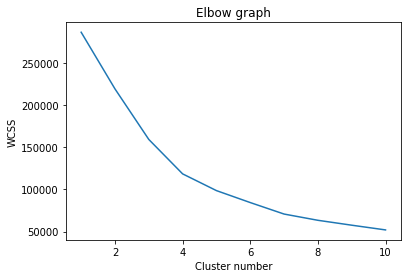

In [210]:
#選擇K值為6
plt.plot(range(1, 11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

In [211]:
#找出k值後，建立model
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(order_nor)

In [212]:
order_rfm_s['clusters'] = clusters
order_rfm_s.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95420 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 4 columns):
recency           95420 non-null float64
frequency         95420 non-null int64
monetary_value    95420 non-null float64
clusters          95420 non-null int32
dtypes: float64(2), int32(1), int64(1)
memory usage: 3.3+ MB


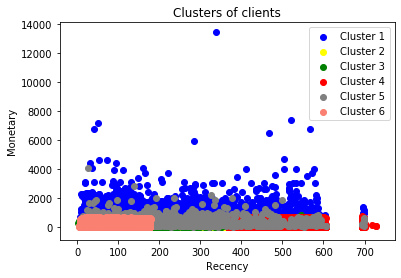

In [213]:
c1 = order_rfm_s[order_rfm_s.clusters == 0]
c2 = order_rfm_s[order_rfm_s.clusters == 1]
c3 = order_rfm_s[order_rfm_s.clusters == 2]
c4 = order_rfm_s[order_rfm_s.clusters == 3]
c5 = order_rfm_s[order_rfm_s.clusters == 4]
c6 = order_rfm_s[order_rfm_s.clusters == 5]
c7 = order_rfm_s[order_rfm_s.clusters == 6]

plt.scatter(c1.recency, c1.monetary_value, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.recency, c2.monetary_value, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.recency, c3.monetary_value, c = 'green', label = 'Cluster 3')
plt.scatter(c4.recency, c4.monetary_value, c = 'red', label = 'Cluster 4')
plt.scatter(c5.recency, c5.monetary_value, c = 'grey', label = 'Cluster 5')
plt.scatter(c6.recency, c6.monetary_value, c = 'salmon', label = 'Cluster 6')

plt.title('Clusters of clients')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend()

In [214]:
#辨視各cluster的特徵
order_cluster = order_rfm_s.groupby('clusters').agg({'recency': lambda x:sum(x)/float(len(x)),
                                        'frequency': lambda x: sum(x)/float(len(x)),               
                                        'monetary_value': lambda x: sum(x)/float(len(x))})          

order_cluster

,recency,frequency,monetary_value
clusters,,,
0,243.454239,1.185453,1178.252524
1,262.134054,1.000000,108.404764
2,206.969041,2.175579,174.692473
3,468.845807,1.058002,111.796995
4,237.812712,5.079661,365.621661
5,92.764393,1.000000,109.743976


In [215]:
#將上述的cluster新加到使用者的特徵
order_sim= order_rfm.copy()
order_sim=pd.merge(order_sim, review, on='order_id')
order_sim=pd.merge(order_sim, order_rfm_s, on='customer_unique_id').drop(['order_id', 'customer_id', 'order_purchase_timestamp', 'order_delivered_customer_date', 'hist', 'recency', 'frequency', 'monetary_value'], axis=1)
order_sim.apply(lambda col:sum(col.isna()))
order_sim.head()

,order_item_id,product_id,price,freight_value,product_category_name,customer_unique_id,review_score,clusters
0,1,87285b34884572647811a353c7ac498a,29.99,8.72,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,4,2
1,1,9abb00920aae319ef9eba674b7d2e6ff,35.39,8.72,bebes,7c396fd4830fd04220f754e42b4e5bff,5,2
2,1,87285b34884572647811a353c7ac498a,29.99,7.78,utilidades_domesticas,3a51803cc0d012c3b5dc8b7528cb05f7,4,3
3,1,87285b34884572647811a353c7ac498a,29.99,7.78,utilidades_domesticas,ef0996a1a279c26e7ecbd737be23d235,5,3
4,1,87285b34884572647811a353c7ac498a,29.99,14.10,utilidades_domesticas,e781fdcc107d13d865fc7698711cc572,3,1


<h4>Step 4. 建立推薦模型</h4>
本次使用Apple的TuriCreate套件，因此須將資料整理成符合套件的格式。<br/>
使用三個方法建立推薦模型：<br/>
a. Popularity <br/>
b. Cosin Similarity <br/>
c. Pearson Similarity

In [216]:
order_sim['target'] =1

In [217]:
data_dummy=order_sim[['product_id','customer_unique_id' , 'target']]
data_count=order_sim[['product_id','customer_unique_id' , 'order_item_id']]

In [218]:
a=order_sim.groupby('product_id').agg({'price':lambda x:sum(x)/float(len(x))})
order_sim=pd.merge(order_sim, a, on='product_id')

In [219]:
#因為商品的價格不同，所以使用平均價格當作特徵
order_sim=order_sim.rename(columns = {'price_y':'avg_price', 'price_x':'price'})
order_sim.head()

,order_item_id,product_id,price,freight_value,product_category_name,customer_unique_id,review_score,clusters,target,avg_price
0,1,87285b34884572647811a353c7ac498a,29.99,8.72,utilidades_domesticas,7c396fd4830fd04220f754e42b4e5bff,4,2,1,29.990000
1,1,87285b34884572647811a353c7ac498a,29.99,7.78,utilidades_domesticas,3a51803cc0d012c3b5dc8b7528cb05f7,4,3,1,29.990000
2,1,87285b34884572647811a353c7ac498a,29.99,7.78,utilidades_domesticas,ef0996a1a279c26e7ecbd737be23d235,5,3,1,29.990000
3,1,87285b34884572647811a353c7ac498a,29.99,14.10,utilidades_domesticas,e781fdcc107d13d865fc7698711cc572,3,1,1,29.990000
4,1,9abb00920aae319ef9eba674b7d2e6ff,35.39,8.72,bebes,7c396fd4830fd04220f754e42b4e5bff,5,2,1,37.288235


In [220]:
user_data=test.copy()
item_data=order_sim[['product_id', 'product_category_name', 'avg_price']].drop_duplicates('product_id')
item_data.head()

,product_id,product_category_name,avg_price
0,87285b34884572647811a353c7ac498a,utilidades_domesticas,29.990000
4,9abb00920aae319ef9eba674b7d2e6ff,bebes,37.288235
21,595fac2a385ac33a80bd5114aec74eb8,perfumaria,119.216038
127,0e2d365a247d105fefc31b17ab8706d9,perfumaria,122.768966
156,c1388e458b5dd74dd3fa304896e8c00d,perfumaria,29.900000


In [221]:
item_data_category = pd.get_dummies(item_data, columns = ['product_category_name'])

In [222]:

test = order_rfm_s.reset_index()
list_c = list(test['customer_unique_id'])
customer_list = random.sample(list_c, 1000)
len(customer_list)

1000

In [223]:
def split_data(data):
    '''
    Splits dataset into training and test set.
    
    Args:
        data (pandas.DataFrame)
        
    Returns
        train_data (tc.SFrame)
        test_data (tc.SFrame)
    '''
    train, test = train_test_split(data, test_size = .2)
    train_data = tc.SFrame(train)
    test_data = tc.SFrame(test)
    return train_data, test_data

In [224]:
train_data, test_data = split_data(data_count)
train_data_dummy, test_data_dummy = split_data(data_dummy)

In [238]:
user_id = 'customer_unique_id'
item_id = 'product_id'
user_data = tc.SFrame(user_data)
item_data = tc.SFrame(item_data_category)
users_to_recommend = customer_list
n_rec = 10 
n_display = 30 

In [226]:
print(test_data)

+-------------------------------+-------------------------------+---------------+
|           product_id          |       customer_unique_id      | order_item_id |
+-------------------------------+-------------------------------+---------------+
| 0c46bfb6210825d07804a6d4f8... | 1a8fb416e145a099289e11115e... |       1       |
| 115e606ac8059e4cfa1c6c3310... | af2e8236fa3043ae9b3efff5dc... |       1       |
| f3c5707e7c539ab6533e3611da... | 071cd8999ac70f2b72112bc3d4... |       1       |
| 7efbc2ce01bc5ac5d5390c330f... | c79719fb0dffa4835479293c56... |       1       |
| 80b5182ab2afa5091844c94a01... | 5d7873ae8c095b4aa1ad87e53a... |       1       |
| eeba3ee5aa7d1d571752248eb4... | 19560db94472cdf51948e02929... |       3       |
| 8e312c483d79e02dbc1d68cce7... | 64c5854c7d6b7c2daa86fb6e8b... |       1       |
| c0350d6ac413eda4641bf92ab6... | 5cb6b80b0da1832a1e272cdcec... |       1       |
| 3bbb1f94c6871212f10e8c2501... | b92d8ecbc60e7c6176e8f02ec8... |       1       |
| 1dfb36d969d347

In [239]:
def model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec,n_display):
    if name == 'popularity':
        model = tc.popularity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    user_data=user_data,
                                                    item_data=item_data,
                                                    target=target)
    elif name == 'cosine':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    user_data=user_data,
                                                    item_data=item_data,
                                                    target=target, 
                                                    similarity_type='cosine')
    elif name == 'pearson':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    user_data=user_data,
                                                    item_data=item_data,
                                                    target=target, 
                                                    similarity_type='pearson')
        
    recom = model.recommend(users=users_to_recommend, k=n_rec)
    recom.print_rows(n_display)
    return model

In [240]:
name = 'popularity'
target = 'order_item_id'
popularity = model(train_data, name, user_id, item_id, target, customer_list, n_rec,n_display)

Preparing data set.

Data has 90657 observations with 95420 users and 32951 items.

Data prepared in: 0.620966s

90657 observations to process; with 32951 unique items.

recommendations finished on 1000/1000 queries. users per second: 3595.83

+-------------------------------+-------------------------------+
|       customer_unique_id      |           product_id          |
+-------------------------------+-------------------------------+
| 966e108168ffea9f05c036fdd0... | 79ce45dbc2ea29b22b5a261bbb... |
| 966e108168ffea9f05c036fdd0... | 270516a3f41dc035aa87d22022... |
| 966e108168ffea9f05c036fdd0... | 9571759451b1d780ee7c15012e... |
| 966e108168ffea9f05c036fdd0... | bf44071ef18f5c9ded039681c6... |
| 966e108168ffea9f05c036fdd0... | e95fb3a80ca294f39de925b642... |
| 966e108168ffea9f05c036fdd0... | d25bbb182b51d1594fe3b54a27... |
| 966e108168ffea9f05c036fdd0... | 37eb69aca8718e843d897aa7b8... |
| 966e108168ffea9f05c036fdd0... | ac1ad58efc1ebf66bfadc09f29... |
| 966e108168ffea9f05c036fdd0... | d05bb6074b45c20f7a516c239c... |
| 966e108168ffea9f05c036fdd0... | 61b6e5d2e3ee58d2b341b8ef1a... |
| 7f57422760e12c56da14617802... | 79ce45dbc2ea29b22b5a261bbb... |
| 7f57422760e12c56da14617802... | 270516a3f41dc035aa87d22022... |
| 7f574227

In [241]:
name = 'popularity'
target = 'target'
popularity_dummy = model(train_data_dummy, name, user_id, item_id, target, customer_list, n_rec,n_display)

Preparing data set.

Data has 90657 observations with 95420 users and 32951 items.

Data prepared in: 0.585298s

90657 observations to process; with 32951 unique items.

recommendations finished on 1000/1000 queries. users per second: 4805.1

+-------------------------------+-------------------------------+-------+------+
|       customer_unique_id      |           product_id          | score | rank |
+-------------------------------+-------------------------------+-------+------+
| 966e108168ffea9f05c036fdd0... | 67a1e52f1184a4ffecff3b0a80... |  1.0  |  1   |
| 966e108168ffea9f05c036fdd0... | dd330cda72d57600ab101aafaf... |  1.0  |  2   |
| 966e108168ffea9f05c036fdd0... | c87a617241993d71f043ed3985... |  1.0  |  3   |
| 966e108168ffea9f05c036fdd0... | 51dea5d1ada11e6deab755d7ab... |  1.0  |  4   |
| 966e108168ffea9f05c036fdd0... | 86da2c247cca57fe5928cc175e... |  1.0  |  5   |
| 966e108168ffea9f05c036fdd0... | 16734715511e4a408f9b534c74... |  1.0  |  6   |
| 966e108168ffea9f05c036fdd0... | 186052b3f166a0f7227e78b2d2... |  1.0  |  7   |
| 966e108168ffea9f05c036fdd0... | c88c6b94ef95d151a4c6043e26... |  1.0  |  8   |
| 966e108168ffea9f05c036fdd0... | f398dcfdd7c7e5933e300b4a3c... |  1.0  |  9   |
| 966e108168ffea9f05c036fdd0

In [242]:
name = 'cosine'
target = 'order_item_id'
cos = model(train_data, name, user_id, item_id, target, customer_list, n_rec,n_display)

Preparing data set.

Data has 90657 observations with 95420 users and 32951 items.

Data prepared in: 0.572336s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.606ms                        | 1          |

| 48.424ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 4.54s                               | 0                | 0               |

| 19.06s                              | 100              | 32951           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 19.1615s

recommendations finished on 1000/1000 queries. users per second: 2437.53

+-------------------------------+-------------------------------+
|       customer_unique_id      |           product_id          |
+-------------------------------+-------------------------------+
| 966e108168ffea9f05c036fdd0... | 8aa74335629d7d8e4ab23653b0... |
| 966e108168ffea9f05c036fdd0... | dd330cda72d57600ab101aafaf... |
| 966e108168ffea9f05c036fdd0... | c87a617241993d71f043ed3985... |
| 966e108168ffea9f05c036fdd0... | 51dea5d1ada11e6deab755d7ab... |
| 966e108168ffea9f05c036fdd0... | 86da2c247cca57fe5928cc175e... |
| 966e108168ffea9f05c036fdd0... | 4579e87cfe02f4b4eaabb298a2... |
| 966e108168ffea9f05c036fdd0... | 186052b3f166a0f7227e78b2d2... |
| 966e108168ffea9f05c036fdd0... | c88c6b94ef95d151a4c6043e26... |
| 966e108168ffea9f05c036fdd0... | f398dcfdd7c7e5933e300b4a3c... |
| 966e108168ffea9f05c036fdd0... | 893c4e4b07dcb5a590645ddeb8... |
| 7f57422760e12c56da14617802... | 0bcc3eeca39e1064258aa1e932... |
| 7f57422760e12c56da14617802... | 422879e10f46682990de24d770... |
| 7f574227

In [243]:
name = 'cosine'
target = 'target'
cos_dummy = model(train_data_dummy, name, user_id, item_id, target, customer_list, n_rec,n_display)

Preparing data set.

Data has 90657 observations with 95420 users and 32951 items.

Data prepared in: 0.874105s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.165ms                        | 1          |

| 39.51ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.81s                               | 0                | 0               |

| 17.66s                              | 100              | 32951           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 17.7329s

recommendations finished on 1000/1000 queries. users per second: 3501.33

+-------------------------------+-------------------------------+
|       customer_unique_id      |           product_id          |
+-------------------------------+-------------------------------+
| 966e108168ffea9f05c036fdd0... | a38b238734207eeb0388676235... |
| 966e108168ffea9f05c036fdd0... | e41a6ac2f57a273eb0d214c7cb... |
| 966e108168ffea9f05c036fdd0... | 4a345c3b756b1f0089af0f3bf0... |
| 966e108168ffea9f05c036fdd0... | 6f6f3b1a96452e2fbad0cd4f70... |
| 966e108168ffea9f05c036fdd0... | cbdbabc3d8b1a111329afd03a9... |
| 966e108168ffea9f05c036fdd0... | b384160c8fb72e5debfa85d451... |
| 966e108168ffea9f05c036fdd0... | 629cd04871a85607710a2bc120... |
| 966e108168ffea9f05c036fdd0... | 8919fe2519b9ec1fb828896ac4... |
| 966e108168ffea9f05c036fdd0... | d0168e734683113fd736580717... |
| 966e108168ffea9f05c036fdd0... | d51e0a7f437c0d14f560082ed0... |
| 7f57422760e12c56da14617802... | 36f60d45225e60c7da4558b070... |
| 7f57422760e12c56da14617802... | e53e557d5a159f5aa2c5e995df... |
| 7f574227

In [244]:
name = 'pearson'
target = 'order_item_id'
pearson = model(train_data, name, user_id, item_id, target, customer_list, n_rec,n_display)

Preparing data set.

Data has 90657 observations with 95420 users and 32951 items.

Data prepared in: 0.713985s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 4.539ms                        | 1          |

| 41.485ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.77s                               | 0                | 0               |

| 15.64s                              | 100              | 32951           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 15.7042s

recommendations finished on 1000/1000 queries. users per second: 3605.99

+-------------------------------+-------------------------------+
|       customer_unique_id      |           product_id          |
+-------------------------------+-------------------------------+
| 966e108168ffea9f05c036fdd0... | 79ce45dbc2ea29b22b5a261bbb... |
| 966e108168ffea9f05c036fdd0... | 270516a3f41dc035aa87d22022... |
| 966e108168ffea9f05c036fdd0... | 9571759451b1d780ee7c15012e... |
| 966e108168ffea9f05c036fdd0... | bf44071ef18f5c9ded039681c6... |
| 966e108168ffea9f05c036fdd0... | e95fb3a80ca294f39de925b642... |
| 966e108168ffea9f05c036fdd0... | d25bbb182b51d1594fe3b54a27... |
| 966e108168ffea9f05c036fdd0... | 37eb69aca8718e843d897aa7b8... |
| 966e108168ffea9f05c036fdd0... | ac1ad58efc1ebf66bfadc09f29... |
| 966e108168ffea9f05c036fdd0... | 61b6e5d2e3ee58d2b341b8ef1a... |
| 966e108168ffea9f05c036fdd0... | d05bb6074b45c20f7a516c239c... |
| 7f57422760e12c56da14617802... | 79ce45dbc2ea29b22b5a261bbb... |
| 7f57422760e12c56da14617802... | 270516a3f41dc035aa87d22022... |
| 7f574227

In [245]:
name = 'pearson'
target = 'target'
pearson_dummy = model(train_data_dummy, name, user_id, item_id, target, customer_list, n_rec,n_display)

Preparing data set.

Data has 90657 observations with 95420 users and 32951 items.

Data prepared in: 0.737915s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 8.449ms                        | 1          |

| 47.801ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 3.61s                               | 0                | 0               |

| 11.55s                              | 100              | 32951           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 11.6057s

recommendations finished on 1000/1000 queries. users per second: 3406.28

+-------------------------------+-------------------------------+-------+------+
|       customer_unique_id      |           product_id          | score | rank |
+-------------------------------+-------------------------------+-------+------+
| 966e108168ffea9f05c036fdd0... | 67a1e52f1184a4ffecff3b0a80... |  1.0  |  1   |
| 966e108168ffea9f05c036fdd0... | dd330cda72d57600ab101aafaf... |  1.0  |  2   |
| 966e108168ffea9f05c036fdd0... | c87a617241993d71f043ed3985... |  1.0  |  3   |
| 966e108168ffea9f05c036fdd0... | 51dea5d1ada11e6deab755d7ab... |  1.0  |  4   |
| 966e108168ffea9f05c036fdd0... | 86da2c247cca57fe5928cc175e... |  1.0  |  5   |
| 966e108168ffea9f05c036fdd0... | 16734715511e4a408f9b534c74... |  1.0  |  6   |
| 966e108168ffea9f05c036fdd0... | 186052b3f166a0f7227e78b2d2... |  1.0  |  7   |
| 966e108168ffea9f05c036fdd0... | c88c6b94ef95d151a4c6043e26... |  1.0  |  8   |
| 966e108168ffea9f05c036fdd0... | f398dcfdd7c7e5933e300b4a3c... |  1.0  |  9   |
| 966e108168ffea9f05c036fdd0

<h4>Step 5. 模型評估</h4>
比較三個模型的RMSE和Precison-Recall數值

In [246]:
models_w_counts = [popularity, cos, pearson]
models_w_dummy = [popularity_dummy, cos_dummy, pearson_dummy]
names_w_counts = ['Popularity Model on Counts', 'Cosine Similarity on Counts', 'Pearson Similarity on Counts']
names_w_dummy = ['Popularity Model on Dummy', 'Cosine Similarity on Dummy', 'Pearson Similarity on Dummy']

In [247]:
eval_counts = tc.recommender.util.compare_models(test_data, models_w_counts, model_names=names_w_counts)

PROGRESS: Evaluate model Popularity Model on Counts


recommendations finished on 1000/21634 queries. users per second: 4674.34

recommendations finished on 2000/21634 queries. users per second: 5038.54

recommendations finished on 3000/21634 queries. users per second: 4820.54

recommendations finished on 4000/21634 queries. users per second: 4835.92

recommendations finished on 5000/21634 queries. users per second: 4701.13

recommendations finished on 6000/21634 queries. users per second: 4716.8

recommendations finished on 7000/21634 queries. users per second: 4771.89

recommendations finished on 8000/21634 queries. users per second: 4848.27

recommendations finished on 9000/21634 queries. users per second: 4668.78

recommendations finished on 10000/21634 queries. users per second: 4650.08

recommendations finished on 11000/21634 queries. users per second: 4624.58

recommendations finished on 12000/21634 queries. users per second: 4629.24

recommendations finished on 13000/21634 queries. users per second: 4666.4

recommendations finished on 14000/21634 queries. users per second: 4713.81

recommendations finished on 15000/21634 queries. users per second: 4754.42

recommendations finished on 16000/21634 queries. users per second: 4643.36

recommendations finished on 17000/21634 queries. users per second: 4651.53

recommendations finished on 18000/21634 queries. users per second: 4689.74

recommendations finished on 19000/21634 queries. users per second: 4711.97

recommendations finished on 20000/21634 queries. users per second: 4738.96

recommendations finished on 21000/21634 queries. users per second: 4646.63


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    | 2.311176851252638e-05  | 7.703922837508791e-06  |
|   3    | 3.081569135003515e-05  | 1.694863024251944e-05  |
|   4    | 3.466765276878977e-05  | 2.850451449878257e-05  |
|   5    | 4.622353702505325e-05  | 9.783982003636265e-05  |
|   6    | 3.851961418754409e-05  | 9.783982003636265e-05  |
|   7    | 3.962017459290284e-05  | 0.00011324766571138056 |
|   8    | 3.4667652768789867e-05 | 0.00011324766571138056 |
|   9    | 3.081569135003531e-05  | 0.00011324766571138056 |
|   10   | 3.2356475917537306e-05 | 0.00012480354996764425 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.7828727239929034

Per User RMSE (best)
+---------------

recommendations finished on 1000/21634 queries. users per second: 2725.26

recommendations finished on 2000/21634 queries. users per second: 3181.01

recommendations finished on 3000/21634 queries. users per second: 3411.63

recommendations finished on 4000/21634 queries. users per second: 3573.51

recommendations finished on 5000/21634 queries. users per second: 3622.4

recommendations finished on 6000/21634 queries. users per second: 3508.4

recommendations finished on 7000/21634 queries. users per second: 3491.07

recommendations finished on 8000/21634 queries. users per second: 3599.95

recommendations finished on 9000/21634 queries. users per second: 3644.39

recommendations finished on 10000/21634 queries. users per second: 3710.29

recommendations finished on 11000/21634 queries. users per second: 3760.81

recommendations finished on 12000/21634 queries. users per second: 3792.87

recommendations finished on 13000/21634 queries. users per second: 3813.75

recommendations finished on 14000/21634 queries. users per second: 3825.85

recommendations finished on 15000/21634 queries. users per second: 3849.62

recommendations finished on 16000/21634 queries. users per second: 3862.76

recommendations finished on 17000/21634 queries. users per second: 3875.08

recommendations finished on 18000/21634 queries. users per second: 3897.54

recommendations finished on 19000/21634 queries. users per second: 3923.48

recommendations finished on 20000/21634 queries. users per second: 3946.61

recommendations finished on 21000/21634 queries. users per second: 3937.59


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    | 0.0010169178145511687 | 0.0009475825090135916 |
|   2    | 0.0018027179439770733 |  0.003397429971341417 |
|   3    | 0.0012480354996764367 | 0.0035361005824165632 |
|   4    | 0.0014098178792641145 |  0.005361930294906161 |
|   5    | 0.0013404825737265405 |  0.006371144186619862 |
|   6    | 0.0014406335706141486 |  0.008235493513296912 |
|   7    | 0.0013734993858873013 |  0.009094480909679181 |
|   8    | 0.0012075899047795245 |  0.009109888755354189 |
|   9    | 0.0010836851458095793 |  0.009202335829404308 |
|   10   | 0.0009845613386336297 |  0.009294782903454415 |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.3932942628986154

Per User RMSE (best)
+-------------------------------+-----------

recommendations finished on 1000/21634 queries. users per second: 2553.35

recommendations finished on 2000/21634 queries. users per second: 2655.04

recommendations finished on 3000/21634 queries. users per second: 2827.15

recommendations finished on 4000/21634 queries. users per second: 2915.05

recommendations finished on 5000/21634 queries. users per second: 2985.14

recommendations finished on 6000/21634 queries. users per second: 3024.02

recommendations finished on 7000/21634 queries. users per second: 2965.89

recommendations finished on 8000/21634 queries. users per second: 3017.93

recommendations finished on 9000/21634 queries. users per second: 3050.27

recommendations finished on 10000/21634 queries. users per second: 3040.06

recommendations finished on 11000/21634 queries. users per second: 3059.3

recommendations finished on 12000/21634 queries. users per second: 3085.44

recommendations finished on 13000/21634 queries. users per second: 3111.35

recommendations finished on 14000/21634 queries. users per second: 3086.2

recommendations finished on 15000/21634 queries. users per second: 3106.57

recommendations finished on 16000/21634 queries. users per second: 3121.07

recommendations finished on 17000/21634 queries. users per second: 3135.92

recommendations finished on 18000/21634 queries. users per second: 3152.48

recommendations finished on 19000/21634 queries. users per second: 3166.05

recommendations finished on 20000/21634 queries. users per second: 3176.87

recommendations finished on 21000/21634 queries. users per second: 3169.59


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    | 2.311176851252641e-05  | 7.703922837508783e-06  |
|   3    | 3.081569135003513e-05  | 1.694863024251944e-05  |
|   4    | 3.466765276878981e-05  | 2.850451449878267e-05  |
|   5    | 4.622353702505316e-05  | 9.783982003636281e-05  |
|   6    | 3.8519614187544283e-05 | 9.783982003636281e-05  |
|   7    | 3.962017459290277e-05  | 0.00011324766571138024 |
|   8    | 3.466765276878988e-05  | 0.00011324766571138024 |
|   9    | 3.0815691350035185e-05 | 0.00011324766571138024 |
|   10   | 2.7734122215031995e-05 | 0.00011324766571138024 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.7910975387325168

Per User RMSE (best)
+---------------

In [248]:
eval_dummy = tc.recommender.util.compare_models(test_data_dummy, models_w_dummy, model_names=names_w_dummy)

PROGRESS: Evaluate model Popularity Model on Dummy


recommendations finished on 1000/21639 queries. users per second: 4463.85

recommendations finished on 2000/21639 queries. users per second: 4960.5

recommendations finished on 3000/21639 queries. users per second: 5183.82

recommendations finished on 4000/21639 queries. users per second: 5352.33

recommendations finished on 5000/21639 queries. users per second: 5199.18

recommendations finished on 6000/21639 queries. users per second: 4921.83

recommendations finished on 7000/21639 queries. users per second: 4960.69

recommendations finished on 8000/21639 queries. users per second: 5062.95

recommendations finished on 9000/21639 queries. users per second: 5068.17

recommendations finished on 10000/21639 queries. users per second: 4925.25

recommendations finished on 11000/21639 queries. users per second: 4871.71

recommendations finished on 12000/21639 queries. users per second: 4878.53

recommendations finished on 13000/21639 queries. users per second: 4736.34

recommendations finished on 14000/21639 queries. users per second: 4655.66

recommendations finished on 15000/21639 queries. users per second: 4600.53

recommendations finished on 16000/21639 queries. users per second: 4496.85

recommendations finished on 17000/21639 queries. users per second: 4348.89

recommendations finished on 18000/21639 queries. users per second: 4291.05

recommendations finished on 19000/21639 queries. users per second: 4261.97

recommendations finished on 20000/21639 queries. users per second: 4275.66

recommendations finished on 21000/21639 queries. users per second: 4324.01


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    |          0.0           |          0.0           |
|   3    |          0.0           |          0.0           |
|   4    |          0.0           |          0.0           |
|   5    |  9.24257128333109e-06  | 4.621285641665475e-05  |
|   6    | 7.702142736109111e-06  | 4.621285641665475e-05  |
|   7    | 6.601836630950782e-06  | 4.621285641665475e-05  |
|   8    | 5.776607052081843e-06  | 4.621285641665475e-05  |
|   9    | 1.026952364814562e-05  | 9.242571283330982e-05  |
|   10   | 1.3863856924996644e-05 | 0.00013863856924996524 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.42738798502285097

Per User RMSE (best)
+--------------

recommendations finished on 1000/21639 queries. users per second: 2872.12

recommendations finished on 2000/21639 queries. users per second: 3172.38

recommendations finished on 3000/21639 queries. users per second: 3270.35

recommendations finished on 4000/21639 queries. users per second: 3291.91

recommendations finished on 5000/21639 queries. users per second: 3192.41

recommendations finished on 6000/21639 queries. users per second: 3314.29

recommendations finished on 7000/21639 queries. users per second: 3408.3

recommendations finished on 8000/21639 queries. users per second: 3435.33

recommendations finished on 9000/21639 queries. users per second: 3490.91

recommendations finished on 10000/21639 queries. users per second: 3569.22

recommendations finished on 11000/21639 queries. users per second: 3615.81

recommendations finished on 12000/21639 queries. users per second: 3606.19

recommendations finished on 13000/21639 queries. users per second: 3638.42

recommendations finished on 14000/21639 queries. users per second: 3683.06

recommendations finished on 15000/21639 queries. users per second: 3714.77

recommendations finished on 16000/21639 queries. users per second: 3727.73

recommendations finished on 17000/21639 queries. users per second: 3747.11

recommendations finished on 18000/21639 queries. users per second: 3681.6

recommendations finished on 19000/21639 queries. users per second: 3660.74

recommendations finished on 20000/21639 queries. users per second: 3645.01

recommendations finished on 21000/21639 queries. users per second: 3664.96


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    | 0.0010628956975830728 | 0.0009589167706455961 |
|   2    | 0.0009242571283331097 | 0.0017214289015204027 |
|   3    | 0.0007856185590831319 | 0.0021951106797911324 |
|   4    | 0.0006007671334165195 |  0.00224132353620778  |
|   5    | 0.0007578908452331441 |  0.003558389944082463 |
|   6    |  0.001039789269374745 |  0.005815117765762442 |
|   7    | 0.0010034791679045087 |  0.006554523468428927 |
|   8    | 0.0008895974860206126 |  0.00664694918126221  |
|   9    | 0.0007958880827312795 | 0.0066931620376788825 |
|   10   | 0.0007209205600998223 |  0.006739374894095531 |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9999120736065448

Per User RMSE (best)
+-------------------------------+-----------

recommendations finished on 1000/21639 queries. users per second: 2434.9

recommendations finished on 2000/21639 queries. users per second: 2584.87

recommendations finished on 3000/21639 queries. users per second: 2565.01

recommendations finished on 4000/21639 queries. users per second: 2621.73

recommendations finished on 5000/21639 queries. users per second: 2659.28

recommendations finished on 6000/21639 queries. users per second: 2617.95

recommendations finished on 7000/21639 queries. users per second: 2617.81

recommendations finished on 8000/21639 queries. users per second: 2682.08

recommendations finished on 9000/21639 queries. users per second: 2706.23

recommendations finished on 10000/21639 queries. users per second: 2759.24

recommendations finished on 11000/21639 queries. users per second: 2806.49

recommendations finished on 12000/21639 queries. users per second: 2782.85

recommendations finished on 13000/21639 queries. users per second: 2744.34

recommendations finished on 14000/21639 queries. users per second: 2756.31

recommendations finished on 15000/21639 queries. users per second: 2755.53

recommendations finished on 16000/21639 queries. users per second: 2762.78

recommendations finished on 17000/21639 queries. users per second: 2704.22

recommendations finished on 18000/21639 queries. users per second: 2659.17

recommendations finished on 19000/21639 queries. users per second: 2619.51

recommendations finished on 20000/21639 queries. users per second: 2575.45

recommendations finished on 21000/21639 queries. users per second: 2579.67


Precision and recall summary statistics by cutoff
+--------+------------------------+------------------------+
| cutoff |     mean_precision     |      mean_recall       |
+--------+------------------------+------------------------+
|   1    |          0.0           |          0.0           |
|   2    |          0.0           |          0.0           |
|   3    |          0.0           |          0.0           |
|   4    |          0.0           |          0.0           |
|   5    |  9.24257128333109e-06  | 4.6212856416654645e-05 |
|   6    | 1.5404285472218323e-05 | 9.242571283330971e-05  |
|   7    | 1.3203673261901525e-05 | 9.242571283330971e-05  |
|   8    | 1.1553214104163714e-05 | 9.242571283330971e-05  |
|   9    | 1.5404285472218388e-05 | 0.00013863856924996537 |
|   10   | 1.8485142566662103e-05 | 0.00018485142566661942 |
+--------+------------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 0.42738798502285097

Per User RMSE (best)
+--------------

In [249]:
popularity.recommend(["7c396fd4830fd04220f754e42b4e5bff"])

customer_unique_id,product_id,score,rank
7c396fd4830fd04220f754e42b4e5bff ...,79ce45dbc2ea29b22b5a261bbb7b7ee7 ...,21.0,1
7c396fd4830fd04220f754e42b4e5bff ...,270516a3f41dc035aa87d220228f844c ...,16.0,2
7c396fd4830fd04220f754e42b4e5bff ...,9571759451b1d780ee7c15012ea109d4 ...,11.2,3
7c396fd4830fd04220f754e42b4e5bff ...,bf44071ef18f5c9ded039681c68b1996 ...,11.0,4
7c396fd4830fd04220f754e42b4e5bff ...,e95fb3a80ca294f39de925b6428f3a32 ...,8.5,5
7c396fd4830fd04220f754e42b4e5bff ...,d25bbb182b51d1594fe3b54a27ae143e ...,8.5,6
7c396fd4830fd04220f754e42b4e5bff ...,37eb69aca8718e843d897aa7b82f462d ...,8.25,7
7c396fd4830fd04220f754e42b4e5bff ...,ac1ad58efc1ebf66bfadc09f29bdedc0 ...,7.333333333333333,8
7c396fd4830fd04220f754e42b4e5bff ...,d05bb6074b45c20f7a516c239c0a1c43 ...,7.0,9
7c396fd4830fd04220f754e42b4e5bff ...,61b6e5d2e3ee58d2b341b8ef1a652b26 ...,7.0,10
